# FM Features
## Load Data

In [22]:
import mne
import scipy
import peakfrequency.peak_frequency as pf
from mne.channels.layout import _auto_topomap_coords as pos_from_raw
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

'''
fname = 'data/S2/S2_4chns.raw'
raw = mne.io.Raw(fname, preload=True)
data = raw.get_data()
fs = 500
channels = 4
samples = 900
data = data.T
'''
# Load data, set montage and remove bad channels as before
# Load data
path = "data/TF/"
raw = mne.io.read_raw_brainvision(path + "20191201_Cybathlon_TF_Session1_Block1.vhdr", preload=True)
raw2 = mne.io.read_raw_brainvision(path + "20191201_Cybathlon_TF_Session1_Block2.vhdr", preload=True)
# Set montage (location of channels)
raw.rename_channels({'O9': 'I1', 'O10': 'I2'})
raw2.rename_channels({'O9': 'I1', 'O10': 'I2'})
montage = mne.channels.read_montage("standard_1005")
raw.set_montage(montage)
raw2.set_montage(montage)
raw.rename_channels({'I1': 'O9', 'I2': 'O10'})
raw2.rename_channels({'I1': 'O9', 'I2': 'O10'})

# Remove bad channels from analysis-
#raw.info['bads'] = ['F2', 'FFC2h', 'POO10h', 'O2']
raw.info['bads'] = []
picks = mne.pick_types(raw.info, eeg=True, stim=False, exclude='bads')

fs = int(1/raw.times[1])
# Create events from triggers
events = mne.events_from_annotations(raw)[0]
events2 = mne.events_from_annotations(raw2)[0]
# Epoch data (cut up data into trials)
tmin = 1            # time in seconds after trigger the trial should start
tmax = tmin + 5     # time in seconds after trigger the trial should end
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, preload=True, baseline=None, picks=picks)
epochs2 = mne.Epochs(raw2, events2, tmin=tmin, tmax=tmax, preload=True, baseline=None, picks=picks)
data_lhand = epochs['1'].get_data()
data_lhand = np.vstack((data_lhand, epochs2['1'].get_data()))
data_rhand = epochs['2'].get_data()
data_rhand = np.vstack((data_rhand, epochs2['2'].get_data()))
nr_channels = data_rhand[0].shape[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Extracting parameters from data/TF/20191201_Cybathlon_TF_Session1_Block1.vhdr...
Setting channel info structure...
Reading 0 ... 546359  =      0.000 ...  1092.718 secs...
Extracting parameters from data/TF/20191201_Cybathlon_TF_Session1_Block2.vhdr...
Setting channel info structure...
Reading 0 ... 494618  =      0.000 ...   989.236 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  9', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 30', 'Stimulus/S 40']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  9', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 30', 'Stimulus/S 40']
112 matching events found
No b

/home/biropo/anaconda3/envs/signalprocessing/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/biropo/anaconda3/envs/signalprocessing/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-22-ec6ee29ee964>:28: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Pl

In [9]:
data = epochs['5'].get_data()
data = np.vstack((data, epochs2['5'].get_data()))
title = 'TFhug'
nr_channels = data[0].shape[0]

## Optimizing Alpha Range

In [10]:
def get_tripple(l, u, name):
    name = name+' ('+str(l)+' , '+str(u)+')'
    return float(l), float(u), name

def reset_band_bounds(bands, sub, obj, sup, l, u):
        bands[sub] = get_tripple(bands[sub][0], l, sub)
        bands[obj] = get_tripple(l, u, obj)
        bands[sup] = get_tripple(u, bands[sup][1], sup)
        return bands

def score_product(a, b):
    return a*b

def swap_score(score, best_score, lim, best_lim):
    if score > best_score:
        return score, lim
    else: 
        return best_score, best_lim

def optimize_alpha(data, bands = {'Delta': (get_tripple(1, 4,'Delta')), 'Theta': (get_tripple(4, 8,'Theta')), 'Alpha': (get_tripple(8, 12,'Alpha')), 'Beta': (get_tripple(12, 30, 'Beta')), 'Gamma': (get_tripple(30, 45,'Gamma'))}, 
                   lower=9, upper=10, lower_bound=7, upper_bound=15):
    best_score = 0
    best_lower = lower
    best_upper = upper
    while lower > lower_bound : 
        bands = reset_band_bounds(bands, 'Theta', 'Alpha', 'Beta', lower, upper)
        peakf = pf.PeakFrequency(nr_channels, samples, fs, bands)
        scores = peakf.transform(data.T, 'median')
        score = score_product(scores['Alpha'][4], scores['Alpha'][5])
        best_score, best_lower = swap_score(score, best_score, lower, best_lower)
        lower = lower-1
    best_score = 0      
    while upper < upper_bound : 
        bands = reset_band_bounds(bands, 'Theta', 'Alpha', 'Beta', lower, upper)
        peakf = pf.PeakFrequency(nr_channels, samples, fs, bands)
        scores = peakf.transform(data.T, 'median')
        score = score_product(scores['Alpha'][4], scores['Alpha'][5])
        best_score, best_upper = swap_score(score, best_score, upper, best_upper)
        upper = upper+1
        bands = reset_band_bounds(bands, 'Theta', 'Alpha', 'Beta', best_lower, best_upper)
    return bands

def get_mne_ready():
    return list(optimize_alpha().values())

samples = 125
bands_r = optimize_alpha(data_rhand[0,:,:125])
bands_l = optimize_alpha(data_lhand[0,:,:125])
print(bands_r)
print(bands_l)
bands = bands_l

{'Delta': (1.0, 4.0, 'Delta (1 , 4)'), 'Theta': (4.0, 9.0, 'Theta (4.0 , 9)'), 'Alpha': (9.0, 12.0, 'Alpha (9 , 12)'), 'Beta': (12.0, 30.0, 'Beta (12 , 30.0)'), 'Gamma': (30.0, 45.0, 'Gamma (30 , 45)')}
{'Delta': (1.0, 4.0, 'Delta (1 , 4)'), 'Theta': (4.0, 9.0, 'Theta (4.0 , 9)'), 'Alpha': (9.0, 12.0, 'Alpha (9 , 12)'), 'Beta': (12.0, 30.0, 'Beta (12 , 30.0)'), 'Gamma': (30.0, 45.0, 'Gamma (30 , 45)')}


## Topograpy Maps
*Alpha range, via trial, FM features*

In [5]:
bands = {'Delta': (1.0, 4.0, 'Delta (1 , 4)'), 'Theta': (4.0, 8.0, 'Theta (4.0 , 8)'), 'Alpha': (8.0, 12.0, 'Alpha (9 , 12)'), 'Beta': (12.0, 30.0, 'Beta (12 , 30.0)'), 'Gamma': (30.0, 45.0, 'Gamma (30 , 45)')}

In [20]:
import peakfrequency.peak_frequency as pf
def plot_single_topomap(data, pos, vmin=None, vmax=None, title=None, cmap_rb=False):
    vmin = np.min(data) if vmin is None else vmin
    vmax = np.max(data) if vmax is None else vmax
    fig, ax  = plt.subplots()
    im, _ = mne.viz.topomap.plot_topomap(data, pos, vmin=vmin, vmax=vmax, axes=ax, image_interp='bilinear', contours=0, outlines='skirt', show=False)
    cbar, cax = mne.viz.topomap._add_colorbar(ax, im, None, pad=.25, title=None,
                                  size="10%", format='%3.3f')
    cbar.set_ticks((vmin, vmax))
    ax.set_title(title)
    plt.savefig(title+".png", dpi=150)

fm = pf.PeakFrequency(nr_channels, data_lhand.shape[2], fs, bands)
acum_y = []
acum_x = []
left =[]
right = []
#peaks_delta = []
#peaks_theta = []
#peaks_alpha = []
#peaks_beta = []
#peaks_gamma = []
for i in range(data_lhand.shape[0]):
    technique = 'rms'
    #peak = fm.transform(data[i,:,:].T, technique)
    #peaks_delta.append(peak['Delta'])
    #peaks_theta.append(peak['Theta'])
    #peaks_alpha.append(peak['Alpha'])
    #peaks_beta.append(peak['Beta'])
    #peaks_gamma.append(peak['Gamma'])
    #for b in bands:
    #    pos = pos_from_raw(raw.info, picks)
    #    plot_single_topomap(peak[b], pos, title = title+' '+technique+' '+bands[b][2]+', trial '+str(i), cmap_rb=True)
    peaks_l = fm.transform(data_lhand[i,:,:].T, 'rms')
    peaks_r = fm.transform(data_rhand[i,:,:].T, 'rms')
    #plot_single_topomap(peaks_l['Alpha'], pos, title = bands['Alpha'][2]+' - left, trial'+str(i), cmap_rb=True)
    #plot_single_topomap(peaks_r['Alpha'], pos, title = bands['Alpha'][2]+' - right, trial'+str(i), cmap_rb=True)
    acum_y.append(peaks_l['Alpha'])
    acum_x.append(0)
    acum_y.append(peaks_r['Alpha'])
    acum_x.append(1)
    left.append(peaks_l['Alpha'])
    right.append(peaks_r['Alpha'])
left = np.array(left)
right = np.array(right)



## Correlation Plots
*Alpha range*

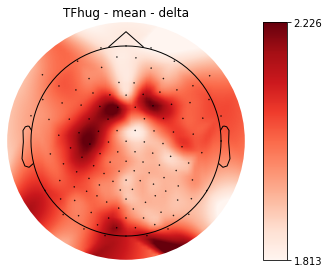

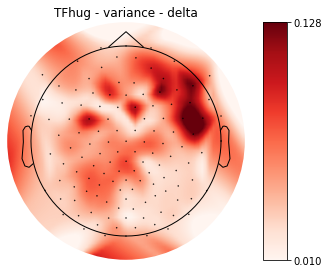

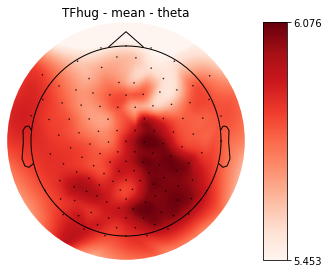

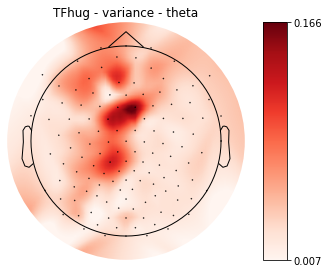

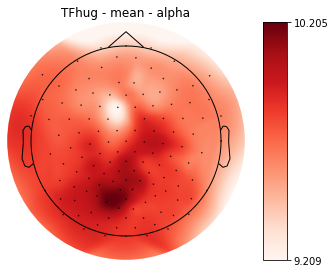

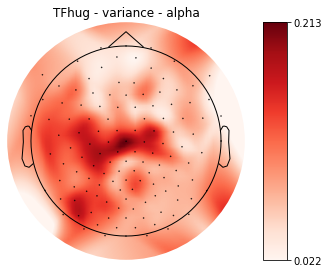

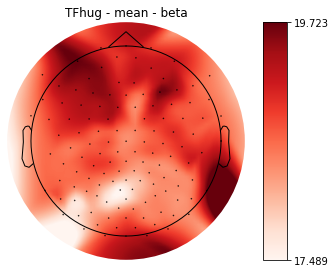

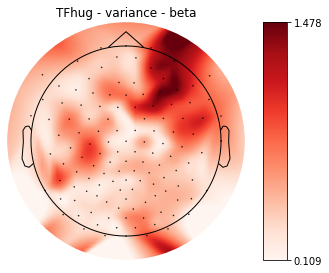

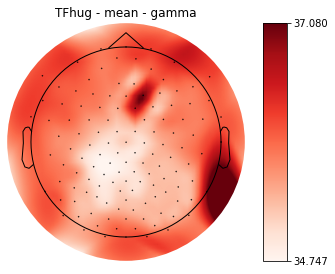

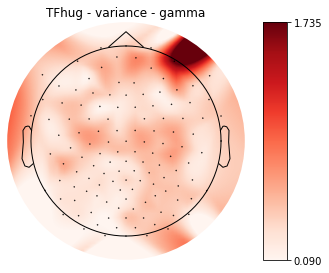

In [11]:
pos = pos_from_raw(raw.info, picks)

peaks = np.array(peaks_delta)
mean = np.mean(peaks, axis=0)
var = np.var(peaks, axis=0)
plot_single_topomap(mean, pos, title = title+' - mean - delta', cmap_rb=True)
plot_single_topomap(var, pos, title = title+' - variance - delta', cmap_rb=True)

peaks = np.array(peaks_theta)
mean = np.mean(peaks, axis=0)
var = np.var(peaks, axis=0)
plot_single_topomap(mean, pos, title = title+' - mean - theta', cmap_rb=True)
plot_single_topomap(var, pos, title = title+' - variance - theta', cmap_rb=True)

peaks = np.array(peaks_alpha)
mean = np.mean(peaks, axis=0)
var = np.var(peaks, axis=0)
plot_single_topomap(mean, pos, title = title+' - mean - alpha', cmap_rb=True)
plot_single_topomap(var, pos, title = title+' - variance - alpha', cmap_rb=True)

peaks = np.array(peaks_beta)
mean = np.mean(peaks, axis=0)
var = np.var(peaks, axis=0)
plot_single_topomap(mean, pos, title = title+' - mean - beta', cmap_rb=True)
plot_single_topomap(var, pos, title = title+' - variance - beta', cmap_rb=True)

peaks = np.array(peaks_gamma)
mean = np.mean(peaks, axis=0)
var = np.var(peaks, axis=0)
plot_single_topomap(mean, pos, title = title+' - mean - gamma', cmap_rb=True)
plot_single_topomap(var, pos, title = title+' - variance - gamma', cmap_rb=True)

mean:  0.1014242734602882
var in mean:  0.007736996402945231


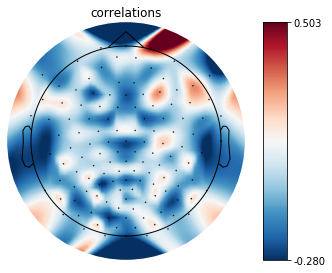

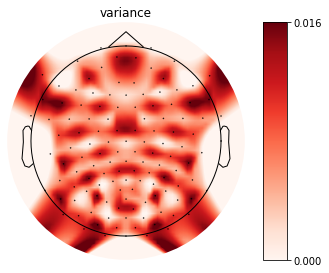

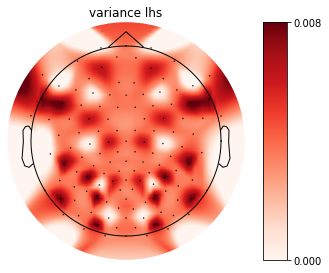

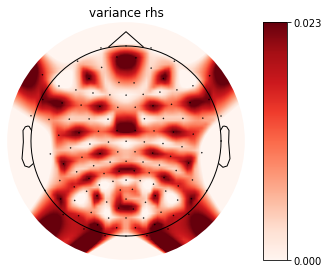

In [21]:
import pandas as pd

y = np.array(acum_y)
val= []
var = []
var_left = []
var_right = []
for i in range(y.shape[1]):
    corr = np.corrcoef(acum_x, y[:, i])
    var.append(np.var(y[:,i]))
    var_left.append(np.var(left[:,i]))
    var_right.append(np.var(right[:,i]))
    val.append(corr[0][1])
print('mean: ', np.mean(np.abs(val)))
print('var in mean: ', np.var(np.abs(val)))
pos = pos_from_raw(raw.info, picks)
plot_single_topomap(val, pos, title = 'correlations', cmap_rb=True)
plot_single_topomap(var, pos, title = 'variance', cmap_rb=True)

plot_single_topomap(var_left, pos, title = 'variance lhs', cmap_rb=True)

plot_single_topomap(var_right, pos, title = 'variance rhs', cmap_rb=True)


## Boxplots

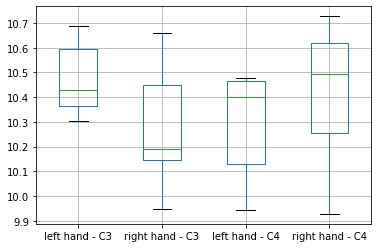

In [57]:
import pandas as pd

l_C3 = left[:, 4]
l_C4 = left[:, 5]
r_C3 = right[:, 4]
r_C4 = right[:, 5]

df = pd.DataFrame(data=[l_C3, r_C3, l_C4, r_C4], index=['left hand - C3', 'right hand - C3', 'left hand - C4', 'right hand - C4']).T
df.boxplot()
plt.savefig("boxplot_hands.png", dpi=150)

## Time Evaluation
*!) caution, do not test the parallelized version*

In [31]:
from timeit import default_timer as timer
import peakfrequency.peak_frequency_parallel as pfpar
samples = data_lhand.shape[2]
data = data_lhand[0,:,:]
print(data.shape)
print('channels: ', nr_channels, ' samples: ', 125,' fs: ', fs, ' bands: ', bands)
for i in [125, 250, 500, 1000]:
    fm = pf.PeakFrequency(nr_channels, i, fs, bands)
    start = timer()
    fm.transform(data.T[:i])
    end = timer()
    frame = i/1000
    elapsed = end - start
    print('time for sample size: ', i, " time elapsed: ", end - start, " fraction: ", int((elapsed/frame)*1000)/10, "% of the samples time frame")



(126, 2501)
channels:  126  samples:  125  fs:  500  bands:  {'Delta': (0, 0), 'Theta': (0, 0), 'Alpha': (0, 0), 'Beta': (0, 0), 'Gamma': (0, 0)}
time for sample size:  125  time elapsed:  0.01845867199881468  fraction:  14.7 % of the samples time frame
time for sample size:  250  time elapsed:  0.027370023999537807  fraction:  10.9 % of the samples time frame
time for sample size:  500  time elapsed:  0.06286333000025479  fraction:  12.5 % of the samples time frame
time for sample size:  1000  time elapsed:  0.16914485100278398  fraction:  16.9 % of the samples time frame


/home/biropo/anaconda3/envs/signalprocessing/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


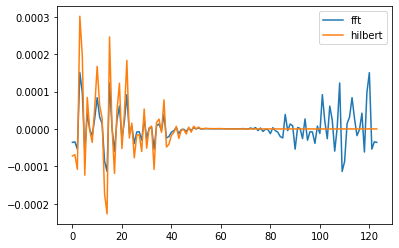

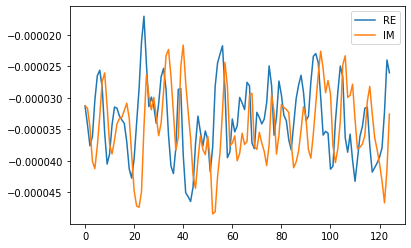

In [68]:
import scipy

dft = scipy.linalg.dft(samples)
idft = np.linalg.inv(dft)
hilbert = np.zeros(samples)
x = data_lhand[0,4,:125]
if samples % 2 == 0:
    hilbert[0] = hilbert[samples // 2] = 1
    hilbert[1:samples // 2] = 2
else:
    hilbert[0] = 1
    hilbert[1:(samples + 1) // 2] = 2
    if nr_channels > 1:
        ind = [np.newaxis] * 2
        ind[-1] = slice(None)
        hilbert = hilbert[tuple(ind)]

H = (dft.dot(x) * hilbert).T
fig, ax  = plt.subplots(nrows=1, ncols=1)
ax.plot(dft.dot(x)[1:], label='fft')
ax.plot(H[1:], label='hilbert')
ax.legend()
plt.savefig("fft.png", dpi=150)

fig, ax  = plt.subplots(nrows=1, ncols=1)
H = H.T.dot(idft).T
ax.plot(np.real(H), label='RE')
ax.plot(np.imag(H)-0.0000347, label="IM")
ax.legend()
plt.savefig("reim.png", dpi=150)

In [28]:
nr_channels = 126
import pandas as pd

df_delta = None
df_theta = None
df_alpha = None
df_beta = None
df_gamma = None
for epoch in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']:
    data = epochs[epoch].get_data()
    fm = pf.PeakFrequency(nr_channels, data.shape[2], fs, bands)
    technique = 'median'
    peaks_delta = []
    peaks_theta = []
    peaks_alpha = []
    peaks_beta = []
    peaks_gamma = []
    for i in range(data.shape[0]):
        peak = fm.transform(data[i,:,:].T, technique)
        peaks_delta.append(peak['Delta'])
        peaks_theta.append(peak['Theta'])
        peaks_alpha.append(peak['Alpha'])
        peaks_beta.append(peak['Beta'])
        peaks_gamma.append(peak['Gamma'])
    peaks_delta = np.array(peaks_delta)
    peaks_theta = np.array(peaks_theta)
    peaks_alpha = np.array(peaks_alpha)
    peaks_beta = np.array(peaks_beta)
    peaks_gamma = np.array(peaks_gamma)
    if df_alpha is None:
        df_delta = pd.DataFrame(peaks_delta)
        df_theta = pd.DataFrame(peaks_theta)
        df_alpha = pd.DataFrame(peaks_alpha)
        df_beta = pd.DataFrame(peaks_beta)
        df_gamma = pd.DataFrame(peaks_gamma)
        df_delta['label'] = epoch
        df_theta['label'] = epoch
        df_alpha['label'] = epoch
        df_beta['label'] = epoch
        df_gamma['label'] = epoch
    else:
        df_delta1 = pd.DataFrame(peaks_delta)
        df_theta1 = pd.DataFrame(peaks_theta)
        df_alpha1 = pd.DataFrame(peaks_alpha)
        df_beta1 = pd.DataFrame(peaks_beta)
        df_gamma1 = pd.DataFrame(peaks_gamma)
        df_delta1['label'] = epoch
        df_theta1['label'] = epoch
        df_alpha1['label'] = epoch
        df_beta1['label'] = epoch
        df_gamma1['label'] = epoch
        df_delta = df_delta.append(df_delta1)
        df_theta = df_theta.append(df_theta1)
        df_alpha = df_alpha.append(df_alpha1)
        df_beta = df_beta.append(df_beta1)
        df_gamma = df_gamma.append(df_gamma1)       
df_gamma.to_csv('gamma_TF.csv')
df_theta.to_csv('theta_TF.csv')
df_alpha.to_csv('alpha_TF.csv')
df_beta.to_csv('beta_TF.csv')
df_delta.to_csv('delta_TF.csv')

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = df_gamma.drop(['label'], axis=1)
pca.fit(x)
principalComponents = pca.transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
y = df_gamma[['label']]
finalDf = pd.concat([principalDf,  y], axis=1)
print(finalDf.head)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
for target in targets:
    indicesToKeep = finalDf['label'] == target
    print(indicesToKeep.shape)
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , s = 50)
ax.legend(targets)
ax.grid()

ValueError: Shape of passed values is (105, 3), indices imply (55, 3)